In [22]:
import pandas as pd
import numpy as np
import librosa
import os
import warnings

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib as plt
import seaborn as sns


In [23]:
warnings.filterwarnings(action= "ignore")
                        

In [24]:
ROOT_DIR: str = os.getcwd()
DATA_DIR: str = os.path.join(ROOT_DIR, "Dataset")
RESPIRATORY_DIR: str = os.path.join(DATA_DIR, "Respiratory_Sound_Database")
AUDIO_DIR: str = os.path.join (RESPIRATORY_DIR, "audio_and_txt_files")

In [25]:
DemoColumnNames: list = ["Patient number", "Age", "Sex", "Adult BMI (kg/m2)", "Child Weight (kg)", "Child Height (cm)"]
DemoInfo = pd.read_csv(filepath_or_buffer= os.path.join(DATA_DIR, "demographic_info.txt"), delimiter= " ", names= DemoColumnNames)
DemoInfo

,Patient number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm)
0,101,3.00,F,NaN,19.0,99.0
1,102,0.75,F,NaN,9.8,73.0
2,103,70.00,F,33.00,NaN,NaN
3,104,70.00,F,28.47,NaN,NaN
4,105,7.00,F,NaN,32.0,135.0
...,...,...,...,...,...,...
121,222,60.00,M,NaN,NaN,NaN
122,223,NaN,NaN,NaN,NaN,NaN
123,224,10.00,F,NaN,32.3,143.0
124,225,0.83,M,NaN,7.8,74.0


In [26]:
DemoInfo["Adult BMI (kg/m2)"].fillna(value= (DemoInfo["Child Weight (kg)"]/(DemoInfo["Child Height (cm)"] * 10 ** -2) ** 2), inplace= True)
DemoInfo

,Patient number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm)
0,101,3.00,F,19.385777,19.0,99.0
1,102,0.75,F,18.389942,9.8,73.0
2,103,70.00,F,33.000000,NaN,NaN
3,104,70.00,F,28.470000,NaN,NaN
4,105,7.00,F,17.558299,32.0,135.0
...,...,...,...,...,...,...
121,222,60.00,M,NaN,NaN,NaN
122,223,NaN,NaN,NaN,NaN,NaN
123,224,10.00,F,15.795393,32.3,143.0
124,225,0.83,M,14.243974,7.8,74.0


In [27]:
DemoInfo["Is_Adult"] = pd.isna(DemoInfo["Child Weight (kg)"]).astype("int32")
DemoInfo

,Patient number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm),Is_Adult
0,101,3.00,F,19.385777,19.0,99.0,0
1,102,0.75,F,18.389942,9.8,73.0,0
2,103,70.00,F,33.000000,NaN,NaN,1
3,104,70.00,F,28.470000,NaN,NaN,1
4,105,7.00,F,17.558299,32.0,135.0,0
...,...,...,...,...,...,...,...
121,222,60.00,M,NaN,NaN,NaN,1
122,223,NaN,NaN,NaN,NaN,NaN,1
123,224,10.00,F,15.795393,32.3,143.0,0
124,225,0.83,M,14.243974,7.8,74.0,0


In [28]:
DemoInfo.drop(labels= ["Child Weight (kg)", "Child Height (cm)"], axis= 1, inplace= True)
DemoInfo.rename(columns= {"Adult BMI (kg/m2)": "BMI (kg/m2)"}, inplace= True)
DemoInfo

,Patient number,Age,Sex,BMI (kg/m2),Is_Adult
0,101,3.00,F,19.385777,0
1,102,0.75,F,18.389942,0
2,103,70.00,F,33.000000,1
3,104,70.00,F,28.470000,1
4,105,7.00,F,17.558299,0
...,...,...,...,...,...
121,222,60.00,M,NaN,1
122,223,NaN,NaN,NaN,1
123,224,10.00,F,15.795393,0
124,225,0.83,M,14.243974,0


In [29]:
Results = pd.read_csv(filepath_or_buffer= os.path.join(RESPIRATORY_DIR, "patient_diagnosis.csv"), names= ["Patient number", "Diagnosis"])
Results

,Patient number,Diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI
...,...,...
121,222,COPD
122,223,COPD
123,224,Healthy
124,225,Healthy


In [30]:
Results.drop("Patient number", axis= 1, inplace= True)
FinalDF = pd.concat([DemoInfo, Results], axis= 1)
FinalDF

,Patient number,Age,Sex,BMI (kg/m2),Is_Adult,Diagnosis
0,101,3.00,F,19.385777,0,URTI
1,102,0.75,F,18.389942,0,Healthy
2,103,70.00,F,33.000000,1,Asthma
3,104,70.00,F,28.470000,1,COPD
4,105,7.00,F,17.558299,0,URTI
...,...,...,...,...,...,...
121,222,60.00,M,NaN,1,COPD
122,223,NaN,NaN,NaN,1,COPD
123,224,10.00,F,15.795393,0,Healthy
124,225,0.83,M,14.243974,0,Healthy


In [31]:
FinalDF.isnull().sum()

Patient number    0
Age               1
Sex               1
BMI (kg/m2)       9
Is_Adult          0
Diagnosis         0
dtype: int64

In [32]:
FinalDF["Age"].fillna(value= FinalDF["Age"].mean(), inplace= True)
FinalDF["Sex"].fillna(value= FinalDF["Sex"].mode()[0], inplace= True)
FinalDF["BMI (kg/m2)"].fillna(value= FinalDF["BMI (kg/m2)"].mean(), inplace= True)
FinalDF.isnull().sum()

Patient number    0
Age               0
Sex               0
BMI (kg/m2)       0
Is_Adult          0
Diagnosis         0
dtype: int64

In [33]:
audio_files = [File for File in os.listdir(AUDIO_DIR) if File.endswith('.wav')]

features_list: list = []

LocationsDict = {"Tc": "Trachea", "Al": "Anterior Left","Ar": "Anterior Right", "Pl": "Posterior Left", 
                    "Pr": "Posterior Right", "Ll": "Lateral Left", "Lr": "Lateral Right"}

for audio_file in audio_files:
    # Load audio
    audio_path = os.path.join(AUDIO_DIR, audio_file)
    TimeSeriesRep, SampleRate = librosa.load(audio_path, sr=None)
    
    # Load corresponding annotation file
    annot_file: str = audio_file.replace('.wav', '.txt')
    annot_path: str = os.path.join(AUDIO_DIR, annot_file)
    if not os.path.exists(annot_path):
        continue  # Skip if annotation file is missing

    Annot_Path_Features: list = annot_file.split(sep=  '_')

    # Read annotation file
    cycles = pd.read_csv(annot_path, sep='\t', header=None, names=['start', 'end', 'crackles', 'wheezes'])
    
    for idx, row in cycles.iterrows():
        Start_Sample = int(row['start'] * SampleRate)
        End_Sample = int(row['end'] * SampleRate)
        Segment = TimeSeriesRep[Start_Sample:End_Sample]
        
        # Extract spectral features
        MFCC = librosa.feature.mfcc(y=Segment, sr=SampleRate).mean(axis=1)
        Spectral_Centroid = librosa.feature.spectral_centroid(y= Segment, sr= SampleRate).mean()
        Spectral_Bandwidth = librosa.feature.spectral_bandwidth(y= Segment, sr= SampleRate).mean()
        Spectral_Rolloff = librosa.feature.spectral_rolloff(y= Segment, sr= SampleRate).mean()
        Spectral_Flatness = librosa.feature.spectral_flatness(y= Segment).mean()
        Poly_Features = librosa.feature.poly_features(y=Segment, sr=SampleRate).mean(axis=1)
        Zero_Crossing_Rate = librosa.feature.zero_crossing_rate(y= Segment).mean()
        Root_Mean_Square = librosa.feature.rms(y= Segment).mean()
        Chromagram = librosa.feature.chroma_stft(y= Segment, sr= SampleRate).mean(axis=1)   

        features = {
            "Audio File": audio_file,
            "Patient number": int(Annot_Path_Features[0]),
            "Breathing Idx": Annot_Path_Features[1],
            "Chest Location": LocationsDict.get(Annot_Path_Features[2], Annot_Path_Features[2]),
            "Cycle Idx": idx,
            "Has_Crackles": int(row['crackles']),
            "Has_Wheezes": int(row['wheezes']),
            "MFCC Mean": MFCC.tolist(),
            "Spectral Centroid": Spectral_Centroid,
            "Spectral Bandwidth": Spectral_Bandwidth,
            "Spectral Rolloff": Spectral_Rolloff,
            "Spectral Flatness": Spectral_Flatness,
            "Spectral Poly Features": Poly_Features.tolist(),
            "ZCR": Zero_Crossing_Rate,
            "RMS": Root_Mean_Square,
            "Chromagram": Chromagram.tolist(),
        }
        features_list.append(features)

# Convert to DataFrame for further analysis
Auditorial_Feats_DF = pd.DataFrame(features_list)
Auditorial_Feats_DF.head()

,Audio File,Patient number,Breathing Idx,Chest Location,Cycle Idx,Has_Crackles,Has_Wheezes,MFCC Mean,Spectral Centroid,Spectral Bandwidth,Spectral Rolloff,Spectral Flatness,Spectral Poly Features,ZCR,RMS,Chromagram
0,101_1b1_Al_sc_Meditron.wav,101,1b1,Anterior Left,0,0,0,"[-527.3826293945312, 92.48876190185547, 67.202...",358.772366,1647.322801,453.571725,0.000128,"[-3.524949766512298e-05, 0.5224251664606512]",0.001153,0.071751,"[0.7362536787986755, 0.8133649826049805, 0.882..."
1,101_1b1_Al_sc_Meditron.wav,101,1b1,Anterior Left,1,0,0,"[-529.982666015625, 85.8995590209961, 65.76871...",285.389462,1593.869192,178.512912,0.000023,"[-3.309534719337326e-05, 0.4894416257746788]",0.001203,0.065527,"[0.7472178936004639, 0.826485812664032, 0.8984..."
2,101_1b1_Al_sc_Meditron.wav,101,1b1,Anterior Left,2,0,0,"[-527.8790283203125, 85.51144409179688, 62.140...",340.490324,1712.226896,269.595703,0.000101,"[-3.085592247782179e-05, 0.4568361103866792]",0.000996,0.060758,"[0.7826526761054993, 0.8513240218162537, 0.910..."
3,101_1b1_Al_sc_Meditron.wav,101,1b1,Anterior Left,3,0,0,"[-534.7429809570312, 83.1063461303711, 64.3837...",320.018563,1712.710514,194.061428,0.000033,"[-2.943444371843459e-05, 0.43583348437084335]",0.001268,0.056632,"[0.7472532987594604, 0.8189571499824524, 0.884..."
4,101_1b1_Al_sc_Meditron.wav,101,1b1,Anterior Left,4,0,0,"[-561.406982421875, 87.22449493408203, 67.2863...",314.715291,1744.059247,153.333748,0.000015,"[-2.6293006848617587e-05, 0.3890293660388601]",0.001245,0.052142,"[0.7587364912033081, 0.8258915543556213, 0.888..."


In [34]:
# Ensure 'Patient number' is an integer in both DataFrames for a clean merge
Auditorial_Feats_DF['Patient number'] = Auditorial_Feats_DF['Patient number'].astype(int)
FinalDF['Patient number'] = FinalDF['Patient number'].astype(int)

# 1. Merge the audio features with the patient demographic/diagnosis data
ml_df = pd.merge(Auditorial_Feats_DF, FinalDF, on='Patient number')

# 2. Expand the list-like feature columns
# Create new DataFrames for each list-column and prefix the new columns
mfcc_df = pd.DataFrame(ml_df['MFCC Mean'].tolist()).add_prefix('mfcc_')
poly_df = pd.DataFrame(ml_df['Spectral Poly Features'].tolist()).add_prefix('poly_')
chroma_df = pd.DataFrame(ml_df['Chromagram'].tolist()).add_prefix('chroma_')

# Combine the new feature columns with the main DataFrame
ml_df = pd.concat([ml_df, mfcc_df, poly_df, chroma_df], axis=1)

# Drop the original list-based columns and other identifiers not needed for training
ml_df.drop(columns=['MFCC Mean', 'Spectral Poly Features', 'Chromagram', 
                     'Audio File', 'Patient number', 'Breathing Idx', 'Cycle Idx'], 
           axis=1, inplace=True)

Feature_Reorder: list = ["Age", "Sex", "BMI (kg/m2)", "Is_Adult", "Diagnosis", "Chest Location", "Has_Crackles", "Has_Wheezes", "Spectral Centroid", "Spectral Bandwidth", "Spectral Rolloff", "Spectral Flatness", "ZCR", "RMS",
                         "mfcc_0", "mfcc_1", "mfcc_2", "mfcc_3", "mfcc_4", "mfcc_5", "mfcc_6", "mfcc_7", "mfcc_8", "mfcc_9", "mfcc_10", "mfcc_11", "mfcc_12", "mfcc_13", "mfcc_14", "mfcc_15", "mfcc_16", "mfcc_17", "mfcc_18", "mfcc_19",
                         "poly_0", "poly_1", "chroma_0", "chroma_1", "chroma_2", "chroma_3", "chroma_4", "chroma_5", "chroma_6", "chroma_7", "chroma_8", "chroma_9", "chroma_10", "chroma_11"]

ml_df = ml_df[Feature_Reorder]

ml_df = pd.get_dummies(ml_df, columns=['Chest Location', 'Sex'], dtype= "int32")

In [35]:
# Synthesis of vitals
# blood pressure, heart rate, oxygen saturation
ml_df["Systolic Blood Pressure (mmHg)"] = np.nan
ml_df["Diastolic Blood Pressure (mmHg)"] =  np.nan
ml_df["Heart Rate (bpm)"] = np.nan
ml_df["Oxygen Saturation (SpO₂%)"] = np.nan

RNGObj = np.random.default_rng(seed=42)

VitalStatsDict = {
    # Each tuple is a Satstical Mean and Std of each parameter
    "Healthy": {
        "SBP": (115, 10),
        "DBP": (75, 8),
        "HR":  (78, 10),
        "SpO2": (98, 1)
    },

    "URTI": {
        "SBP": (115, 12),
        "DBP": (75, 8),
        "HR":  (88, 12),
        "SpO2": (97, 1.5)
    },

    "Asthma": {
        "SBP": (110, 12),
        "DBP": (70, 8),
        "HR":  (120, 15),
        "SpO2": (91, 2)
    },

    "COPD": {
        "SBP": (115, 15),
        "DBP": (72, 9),
        "HR":  (112, 15),
        "SpO2": (86, 3)
    },

    "LRTI": {
        "SBP": (118, 12),
        "DBP": (75, 9),
        "HR":  (100, 14),
        "SpO2": (93, 2)
    },

    "Bronchiectasis": {
        "SBP": (120, 14),
        "DBP": (75, 9),
        "HR":  (110, 14),
        "SpO2": (89, 2.5)
    },

    "Pneumonia": {
        "SBP": (115, 12),
        "DBP": (72, 9),
        "HR":  (118, 15),
        "SpO2": (88, 2.5)
    },

    "Bronchiolitis": {
        "SBP": (78, 10),
        "DBP": (50, 8),
        "HR":  (140, 18),
        "SpO2": (94, 2)
    }
}


for Condition in VitalStatsDict:
    # ConditionRanges[Condition][0] -> Mean
    # ConditionRanges[Condition][1] -> Standard Deviation

    ConditionRanges = VitalStatsDict[Condition]

    ml_df.loc[ml_df["Diagnosis"] == Condition, "Systolic Blood Pressure (mmHg)"] = RNGObj.normal(loc= ConditionRanges["SBP"][0], scale= ConditionRanges["SBP"][1], size= (ml_df["Diagnosis"] == Condition).sum())
    ml_df.loc[ml_df["Diagnosis"] == Condition, "Diastolic Blood Pressure (mmHg)"] = RNGObj.normal(loc= ConditionRanges["DBP"][0], scale= ConditionRanges["DBP"][1], size= (ml_df["Diagnosis"] == Condition).sum())
    ml_df.loc[ml_df["Diagnosis"] == Condition, "Heart Rate (bpm)"] = RNGObj.normal(loc= ConditionRanges["HR"][0], scale= ConditionRanges["HR"][1], size= (ml_df["Diagnosis"] == Condition).sum())
    ml_df.loc[ml_df["Diagnosis"] == Condition, "Oxygen Saturation (SpO₂%)"] = RNGObj.normal(loc= ConditionRanges["SpO2"][0], scale= ConditionRanges["SpO2"][1], size= (ml_df["Diagnosis"] == Condition).sum())

ml_df.head()

,Age,BMI (kg/m2),Is_Adult,Diagnosis,Has_Crackles,Has_Wheezes,Spectral Centroid,Spectral Bandwidth,Spectral Rolloff,Spectral Flatness,...,Chest Location_Lateral Right,Chest Location_Posterior Left,Chest Location_Posterior Right,Chest Location_Trachea,Sex_F,Sex_M,Systolic Blood Pressure (mmHg),Diastolic Blood Pressure (mmHg),Heart Rate (bpm),Oxygen Saturation (SpO₂%)
0,3.0,19.385777,0,URTI,0,0,358.772366,1647.322801,453.571725,0.000128,...,0,0,0,0,1,0,139.042113,77.475133,101.434008,96.009550
1,3.0,19.385777,0,URTI,0,0,285.389462,1593.869192,178.512912,0.000023,...,0,0,0,0,1,0,124.890395,82.851838,91.562990,97.872776
2,3.0,19.385777,0,URTI,0,0,340.490324,1712.226896,269.595703,0.000101,...,0,0,0,0,1,0,117.036479,65.681375,71.838369,97.714904
3,3.0,19.385777,0,URTI,0,0,320.018563,1712.710514,194.061428,0.000033,...,0,0,0,0,1,0,109.731353,91.070043,90.528003,97.022020
4,3.0,19.385777,0,URTI,0,0,314.715291,1744.059247,153.333748,0.000015,...,0,0,0,0,1,0,110.265126,67.324578,74.542827,95.815020


<Axes: xlabel='Diagnosis', ylabel='count'>

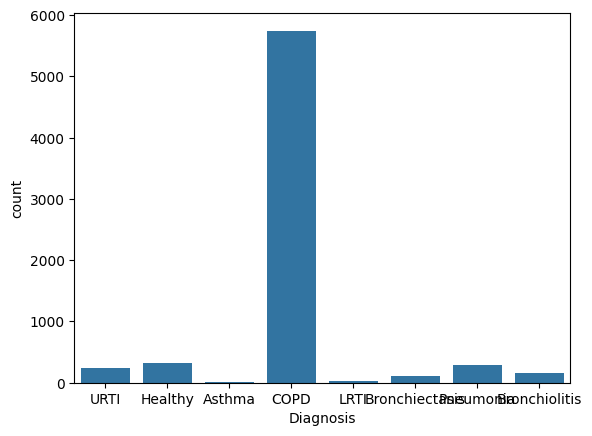

In [36]:
sns.countplot(data= ml_df, x= "Diagnosis")

In [39]:
X = ml_df.drop("Diagnosis", axis= 1)
Y = LabelEncoder().fit_transform(ml_df["Diagnosis"])

In [40]:
X = MinMaxScaler().fit_transform(X)
X

array([[0.0296496 , 0.15518007, 0.        , ..., 0.6160064 , 0.4074372 ,
        0.79609192],
       [0.0296496 , 0.15518007, 0.        , ..., 0.68075638, 0.34031529,
        0.86809401],
       [0.0296496 , 0.15518007, 0.        , ..., 0.47397787, 0.20618988,
        0.86199327],
       ...,
       [0.04043127, 0.06492788, 0.        , ..., 0.64035713, 0.62146294,
        0.56837775],
       [0.04043127, 0.06492788, 0.        , ..., 0.6751515 , 0.61465161,
        0.45280456],
       [0.04043127, 0.06492788, 0.        , ..., 0.55862781, 0.49827244,
        0.61269514]], shape=(6898, 58))

In [41]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size= 0.2, stratify= Y)

In [42]:
X_Train_Resampled, Y_Train_Resampled = SMOTE(k_neighbors= 4).fit_resample(X_Train, Y_Train)

In [43]:
#Re-Adjust Later

ModelsDict = {
        "Multinominal Naive Bayes": MultinomialNB(),
        "XGBoost": XGBClassifier(n_estimators= 100, learning_rate= 0.1, max_depth= 5),
        "Logistic Regression": LogisticRegression(class_weight= "balanced"),
        "Decision Tree": DecisionTreeClassifier(criterion= "gini", max_depth= 5, class_weight= "balanced"),
        "Random Forest": RandomForestClassifier(n_estimators= 100, max_depth= 5, class_weight= "balanced"),
        "Support Vector Machine": SVC(kernel= "rbf", class_weight= "balanced"),
        "K Nearest Neighbors": KNeighborsClassifier(n_neighbors= 6)
    }

SMOTE_Models = ["Multinominal Naive Bayes", "XGBoost", "K Nearest Neighbors"]

for ModelName in  ModelsDict:
    if ModelName in SMOTE_Models:
        ModelsDict[ModelName].fit(X_Train_Resampled, Y_Train_Resampled)
    else:
        ModelsDict[ModelName].fit(X_Train, Y_Train)

StatsDict: dict = {}

for ModelName in ModelsDict:
        if ModelName in SMOTE_Models:
            Train_Pred = ModelsDict[ModelName].predict(X_Train_Resampled)
            Train_True = Y_Train_Resampled
        else:
            Train_Pred = ModelsDict[ModelName].predict(X_Train)
            Train_True = Y_Train

        StatsDict[ModelName] = {"ClassRepObjTest": classification_report(y_true= Y_Test, y_pred=ModelsDict[ModelName].predict(X_Test)),
                                "ClassRepObjTrain": classification_report(y_true= Train_True, y_pred= Train_Pred),
                                "ConfusionMatrixObj": confusion_matrix(y_true= Y_Test, y_pred=ModelsDict[ModelName].predict(X_Test))
                                }
        
        print('=' * 70)
        print(f"for {ModelName}:")
        print('=' * 70)
        print("Training Classification Report")
        print(StatsDict[ModelName]["ClassRepObjTrain"])
        print('=' * 70)
        print("Testing Classification Report")
        print(StatsDict[ModelName]["ClassRepObjTest"])
        print('=' * 70)
        print("Testing Confusion Matrix")
        print(StatsDict[ModelName]["ConfusionMatrixObj"])
        print('=' * 70)

for Multinominal Naive Bayes:
Training Classification Report
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      4596
           1       0.61      0.44      0.51      4596
           2       0.79      0.73      0.76      4596
           3       0.84      0.70      0.76      4596
           4       0.66      0.35      0.46      4596
           5       0.61      1.00      0.76      4596
           6       0.64      0.72      0.68      4596
           7       0.47      0.44      0.46      4596

    accuracy                           0.67     36768
   macro avg       0.68      0.67      0.66     36768
weighted avg       0.68      0.67      0.66     36768

Testing Classification Report
              precision    recall  f1-score   support

           0       0.03      1.00      0.06         1
           1       0.06      0.33      0.10        21
           2       0.74      0.78      0.76        32
           3       0.99      0.69      0.

In [44]:
# Define the model architecture
ANN_Model = Sequential([
    # Input layer - specify input shape
    Dense(128, activation='relu', input_shape=(X_Train_Resampled.shape[1],)),
    Dropout(0.5), # Dropout layer to prevent overfitting
    
    # Hidden layer
    Dense(64, activation='relu'),
    Dropout(0.3),
    
    # Output layer - 8 units for 8 classes, softmax for multi-class probability
    Dense(8, activation='softmax') 
])

# Compile the model
ANN_Model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # Use this loss because your Y is integer-encoded
    metrics=['accuracy']
)

# Use EarlyStopping to prevent overfitting
Early_Stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = ANN_Model.fit(
    X_Train_Resampled, 
    Y_Train_Resampled,
    epochs=100,
    validation_split=0.2, # Use part of the training data for validation
    callbacks=[Early_Stopping],
    batch_size=32,
    verbose=1
)

# Evaluate the ANN on the clean test set
print("\n--- ANN Final Performance ---")
ANN_Pred = np.argmax(ANN_Model.predict(X_Test), axis=1)
print(classification_report(Y_Test, ANN_Pred))

Epoch 1/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8226 - loss: 0.5472 - val_accuracy: 0.3083 - val_loss: 2.5152
Epoch 2/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9546 - loss: 0.1542 - val_accuracy: 0.3725 - val_loss: 2.3539
Epoch 3/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9695 - loss: 0.1047 - val_accuracy: 0.3903 - val_loss: 2.2852
Epoch 4/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9738 - loss: 0.0873 - val_accuracy: 0.4047 - val_loss: 1.7041
Epoch 5/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9782 - loss: 0.0759 - val_accuracy: 0.4082 - val_loss: 1.8160
Epoch 6/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9787 - loss: 0.0695 - val_accuracy: 0.4243 - val_loss: 1.5411
Epoch 7/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9803 - loss: 0.0652 - val_accuracy: 0.4275 - val_loss: 1.4884
Epoch 8/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9813 - loss: 0.0619 - val_accu

In [47]:
ANN_Model.save("Final Predictor Prototype.keras")